## Packages

In [140]:
!pip install pyro-ppl

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import random
import math
import torch
import os
import arviz as az

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, HMC

from sklearn.model_selection import train_test_split

## Setup

In [142]:
def g(x):
    return -torch.sin(6 * math.pi * x)**2 - 6*(x**2) - 5 * (x**4) + 3/2

In [143]:
def generate_dataset(random_state):
    l = 30
    xis = torch.tensor(np.linspace(0,1,l))
    yis = g(xis) + np.random.normal(0, 0.01, len(xis))
    xis_train, xis_test, yis_train, yis_test = train_test_split(xis,  yis, test_size=0.33, random_state = random_state)
    return xis_train, xis_test, yis_train, yis_test

xis_train, xis_test, yis_train, yis_test = generate_dataset(random_state = 0)
order = np.argsort(xis_train)
xis_train = xis_train[order]
yis_train = yis_train[order]
test_order = np.argsort(xis_test)
xis_test = xis_test[test_order]
yis_test = yis_test[test_order]

In [144]:
print(xis_train)
print(g(xis_train))
print(yis_train)

tensor([0.0000, 0.0345, 0.1034, 0.1379, 0.1724, 0.2069, 0.2414, 0.2759, 0.3103,
        0.4138, 0.4828, 0.5172, 0.5517, 0.6207, 0.6552, 0.6897, 0.7241, 0.7931,
        0.8621, 1.0000], dtype=torch.float64)
tensor([ 1.5000,  1.1266,  0.5722,  1.1182,  1.3055,  0.7611,  0.1596,  0.2339,
         0.6994, -0.6710, -0.2719, -0.5651, -1.4748, -2.1345, -2.0430, -2.6611,
        -3.8017, -4.7253, -5.9862, -9.5000], dtype=torch.float64)
tensor([ 1.5007,  1.1185,  0.5695,  1.1241,  1.3031,  0.7556,  0.1490,  0.2380,
         0.7024, -0.6876, -0.2746, -0.5532, -1.4705, -2.1277, -2.0330, -2.6514,
        -3.8113, -4.7304, -5.9695, -9.5031], dtype=torch.float64)


<Axes: xlabel='None', ylabel='None'>

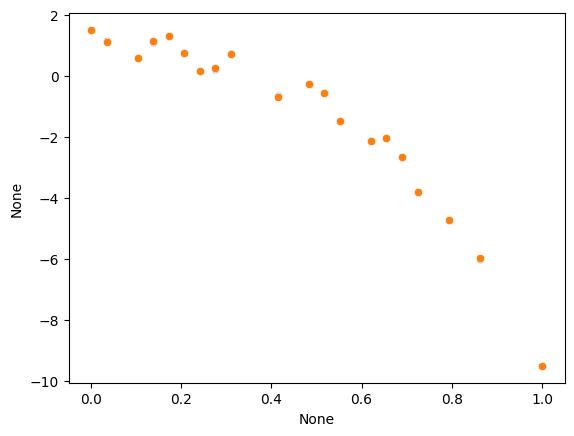

In [145]:
sns.scatterplot(x = xis_train, y = g(xis_train))
sns.scatterplot(x = xis_train, y = yis_train)



## Model

In [146]:
pyro.clear_param_store()
###Priors over kernel parameters
variance_prior = dist.Uniform(torch.tensor(0.0), torch.tensor(10.0))#dist.HalfNormal(torch.tensor(10.0))
lengthscale_prior = dist.HalfNormal(torch.tensor(3.0))
period_prior = dist.HalfNormal(torch.tensor(0.2))
#noise could also be sampled from a prior?
noise_prior = dist.HalfNormal(torch.tensor(0.1))  # Prior for noise



In [147]:
pyro.clear_param_store()
def get_gpr(x_train, y_train, variance_prior, lengthscale_prior, period_prior, noise_prior):
    ###Sample from priors
    pyro.clear_param_store()
    variance = pyro.sample("variance", variance_prior)
    lengthscale = pyro.sample("lengthscale", lengthscale_prior)
    period = pyro.sample("period", period_prior)
    noise = pyro.sample("noise", noise_prior)

    period_kernel = gp.kernels.Periodic(
        input_dim = 1, variance = variance, lengthscale=lengthscale, period=period
    )

    rbf_kernel = gp.kernels.RBF(
        input_dim = 1, variance = variance, lengthscale=lengthscale
    )

    combined_kernel = gp.kernels.Product(
        period_kernel, rbf_kernel
    )

    kernel = combined_kernel

    gpr = gp.models.GPRegression(x_train, y_train, kernel, noise=noise)

    return gpr

In [148]:
gpr = get_gpr(xis_train, yis_train, variance_prior, lengthscale_prior, period_prior, noise_prior)

In [149]:
def plot(
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        ax.plot(xis_train.numpy(), yis_train.numpy(), "x", label = 'train data', c = 'blue')
        ax.plot(xis_test.numpy(), yis_test.numpy(), "x", label = 'test data', c = 'black')
    if plot_predictions:
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(xis_train, full_cov=True)
            else:
                mean, cov = model(xis_train, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(xis_train.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            xis_train.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
        ax.legend()

    if n_prior_samples > 0:  # plot samples from the GP prior
        xs_test = torch.linspace(0, 1, n_test)
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(xs_test) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(xs_test.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    ax.set_xlim(0, 1)


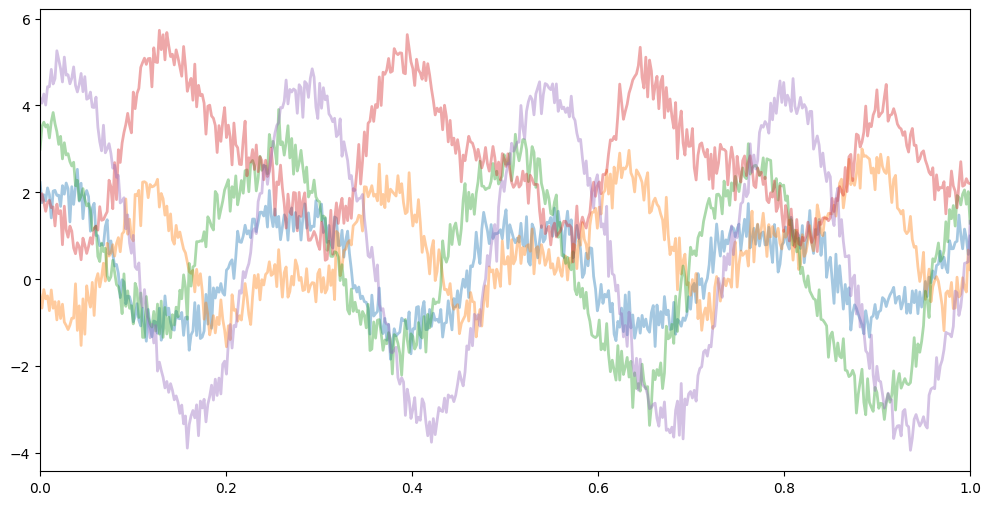

In [150]:
plot(model=gpr, kernel=gpr.kernel, n_prior_samples=5)
#_ = plt.ylim((-8, 8))

## MAP estimate

In [151]:
pyro.clear_param_store()

optimizer = torch.optim.Adam(gpr.parameters(), lr=0.002)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 2000
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())



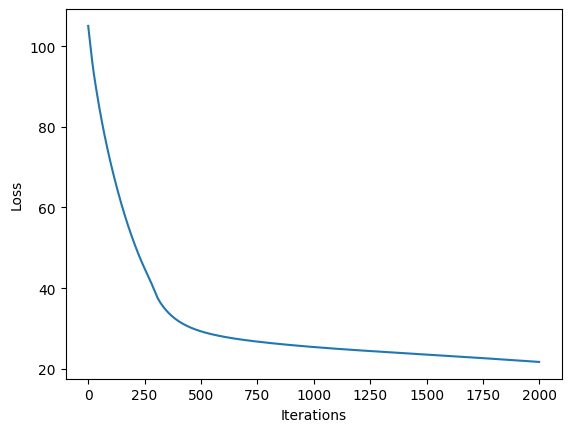

In [152]:
def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text

plot_loss(losses)

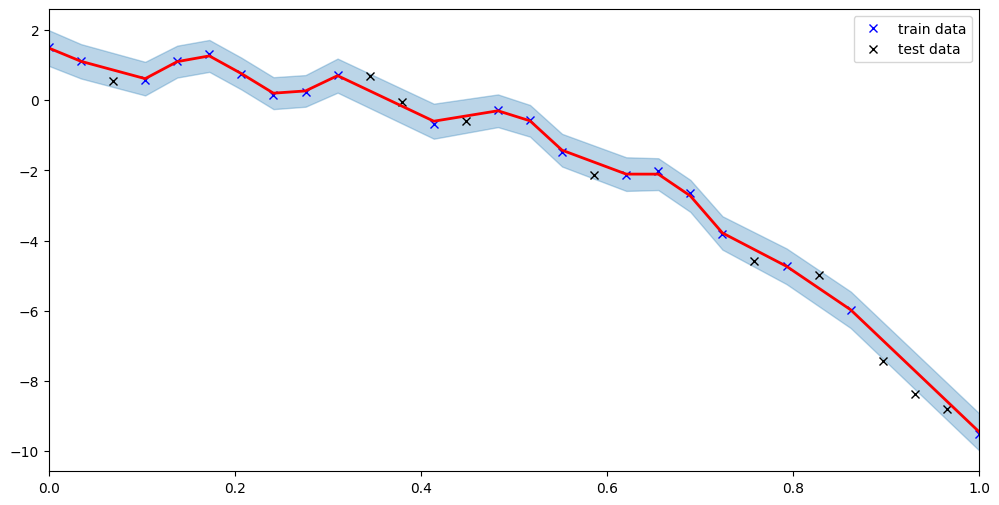

In [153]:
plot(model=gpr, plot_observed_data=True, plot_predictions=True)

In [154]:
def log_likelihood(gpr, x_test, y_test):
    with torch.no_grad():
        predictive_mean, predictive_cov = gpr(x_test, full_cov=True, noiseless=False)

        predictive_distribution = dist.MultivariateNormal(predictive_mean, predictive_cov)

        log_likelihood = predictive_distribution.log_prob(y_test)

        return log_likelihood.item()

log_likelihood(gpr, xis_test, yis_test)

3.753473587686724

## NUTS sampling

In [155]:
pyro.clear_param_store()
def model(x_train, y_train):
    ###Sample from priors
    variance = pyro.sample("variance", variance_prior)
    lengthscale = pyro.sample("lengthscale", lengthscale_prior)
    period = pyro.sample("period", period_prior)
    noise = pyro.sample("noise", noise_prior)

    period_kernel = gp.kernels.Periodic(
        input_dim = 1, variance = variance, lengthscale=lengthscale, period=period
    )

    rbf_kernel = gp.kernels.RBF(
        input_dim = 1, variance = variance, lengthscale=lengthscale
    )

    combined_kernel = gp.kernels.Product(
        period_kernel, rbf_kernel
    )

    kernel = combined_kernel

    gpr = gp.models.GPRegression(x_train, y_train, kernel, noise=noise)

    return gpr.model

In [156]:
nuts = NUTS(model)
mcmc = MCMC(nuts, num_samples=500, warmup_steps=250, num_chains = 4)
mcmc.run(xis_train, yis_train)
samples = mcmc.get_samples()

/usr/local/lib/python3.10/dist-packages/pyro/infer/mcmc/api.py:499: UserWarning: num_chains=4 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(
Sample [3]: 100%|██████████| 750/750 [00:26, 28.06it/s, step size=4.48e-01, acc. prob=0.841]


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
lengthscale  2.432  1.820   0.000    5.749      0.056    0.040     701.0   
noise        0.082  0.063   0.000    0.192      0.002    0.001     836.0   
period       0.165  0.120   0.000    0.384      0.003    0.002    1145.0   
variance     5.062  2.850   0.626    9.997      0.073    0.053    1325.0   

             ess_tail  r_hat  
lengthscale     459.0   1.01  
noise           597.0   1.00  
period          753.0   1.00  
variance        959.0   1.01  


array([<Axes: title={'center': '94.0% HDI'}>,
       <Axes: title={'center': 'ess'}>], dtype=object)

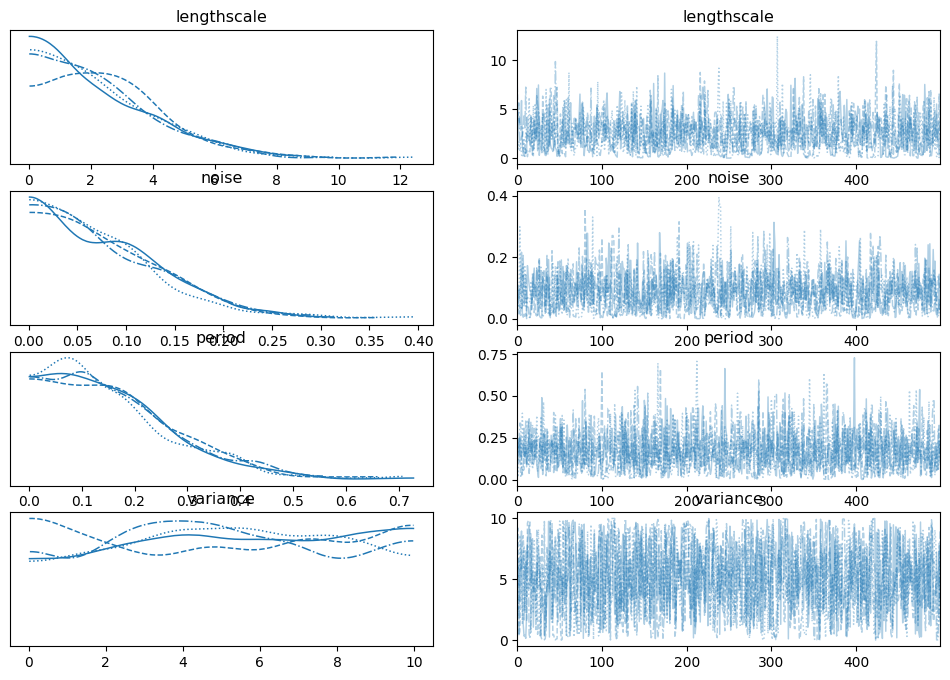

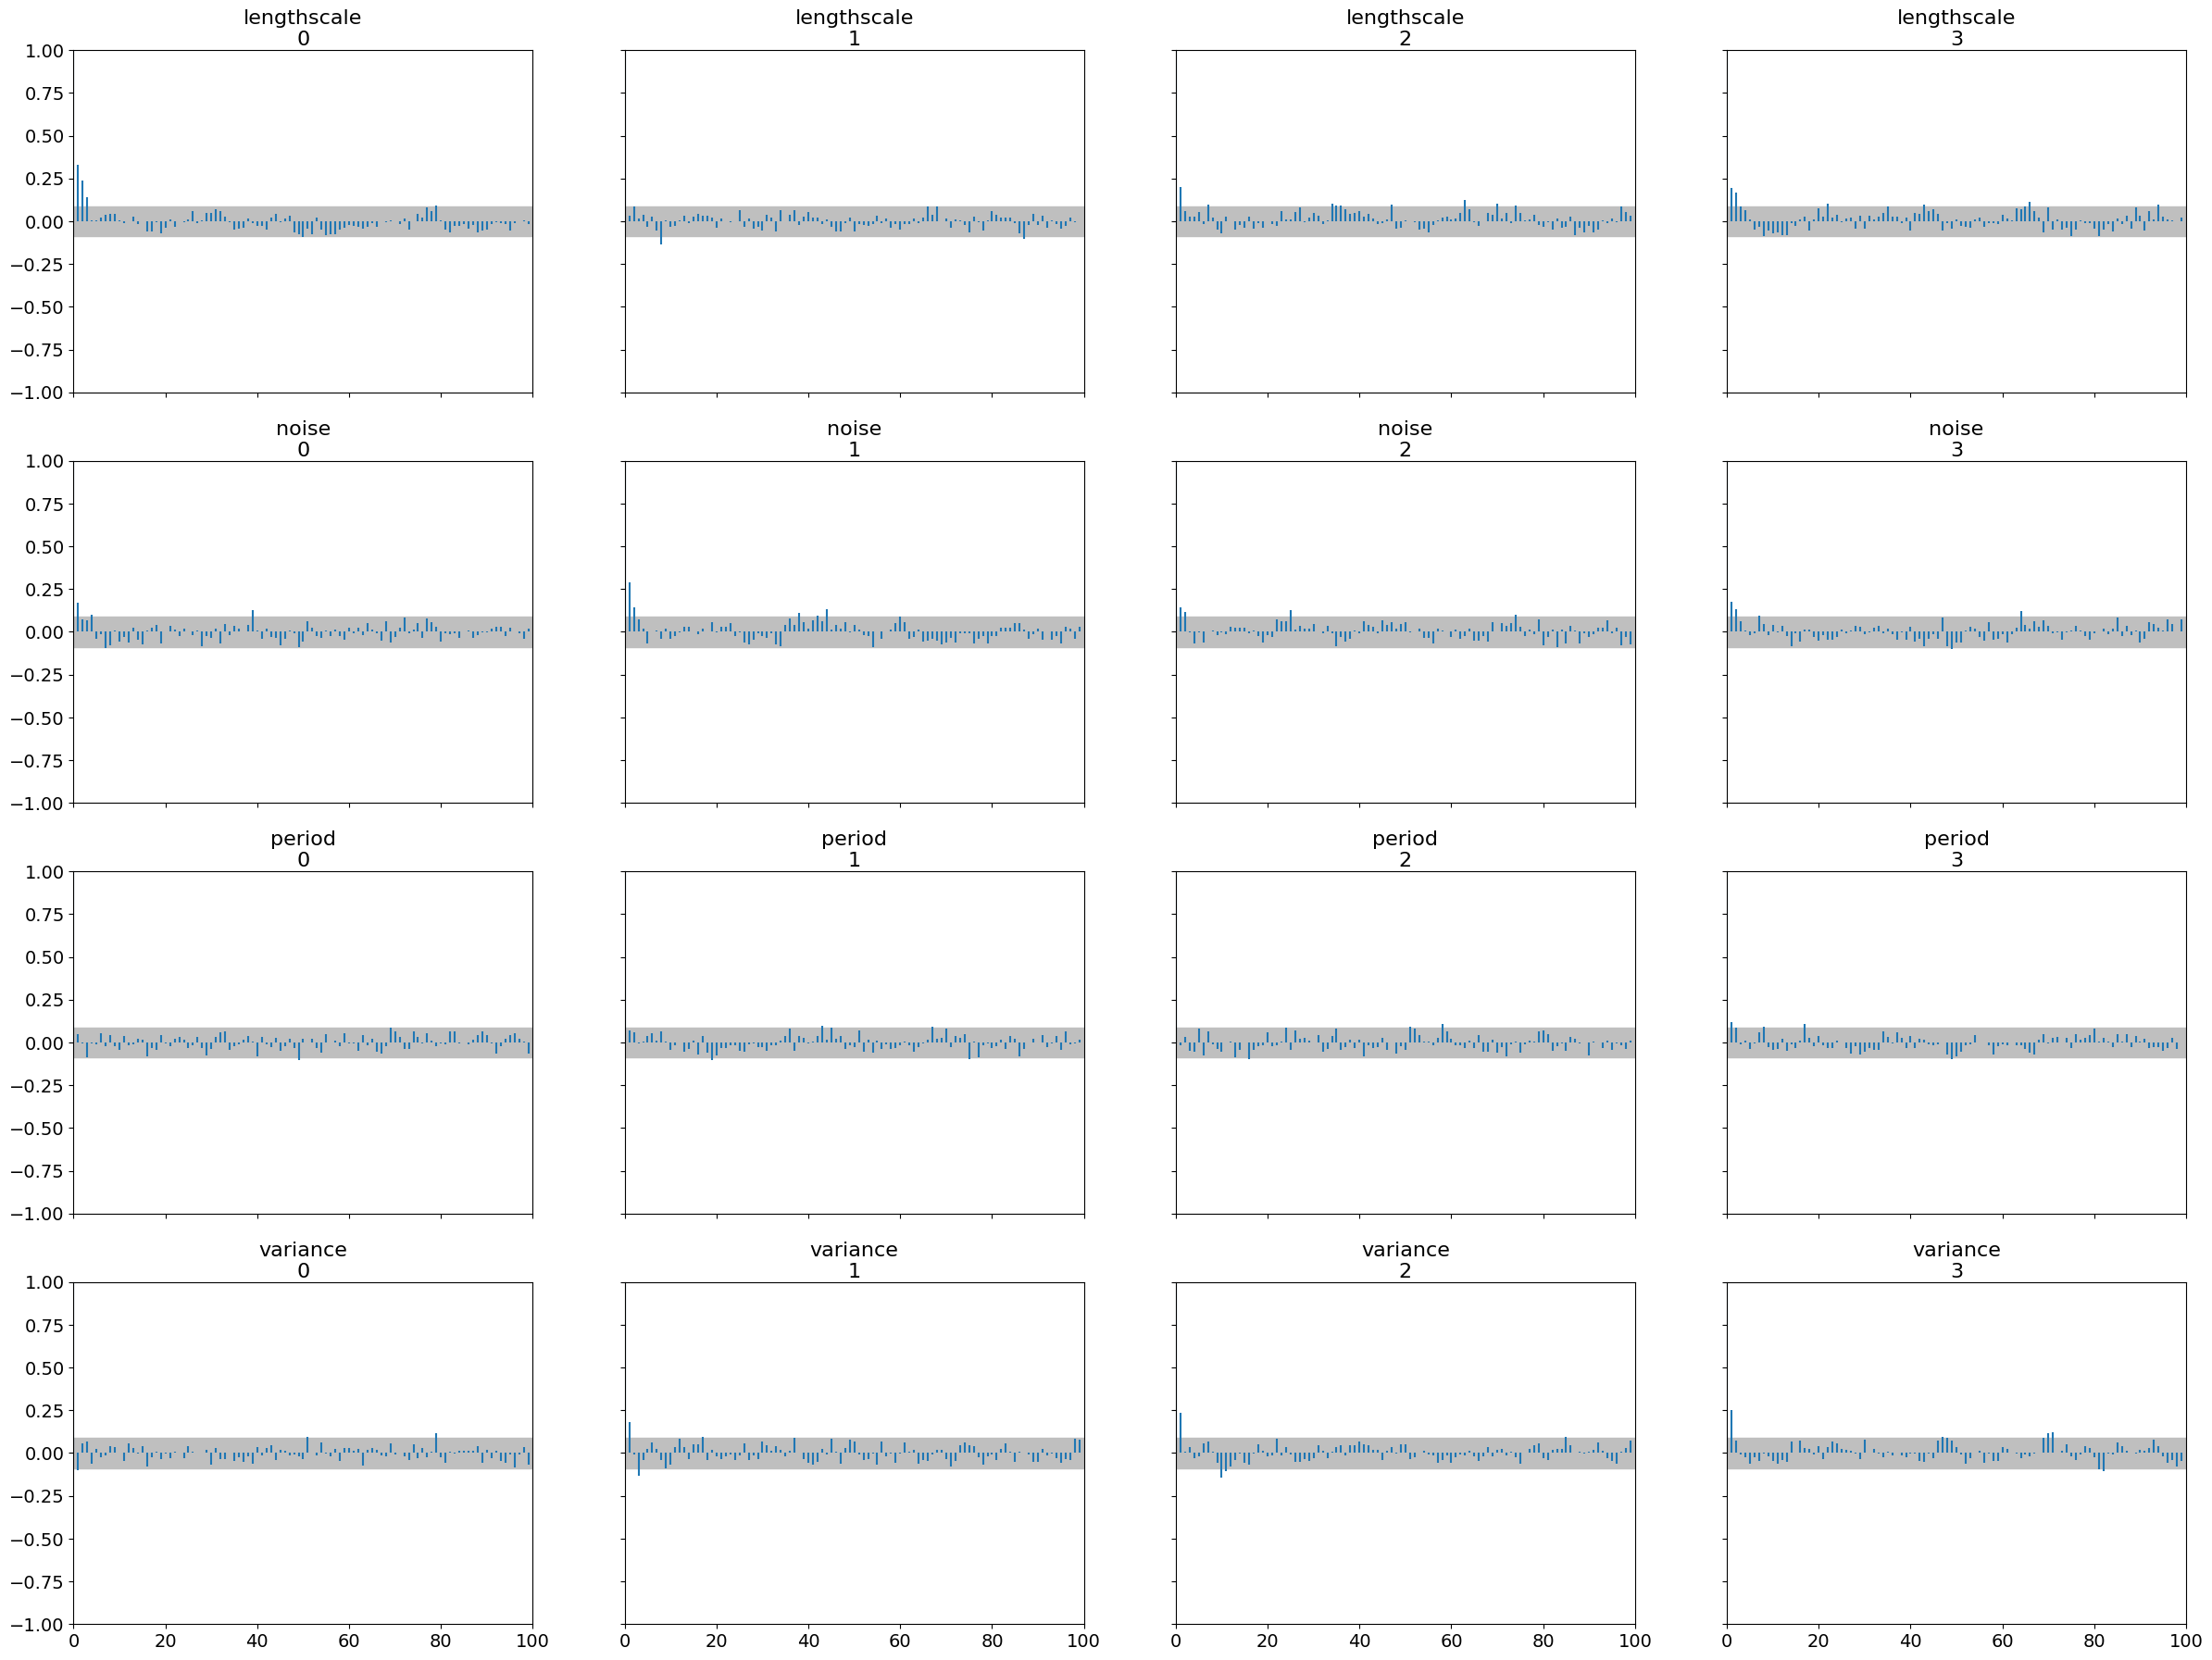

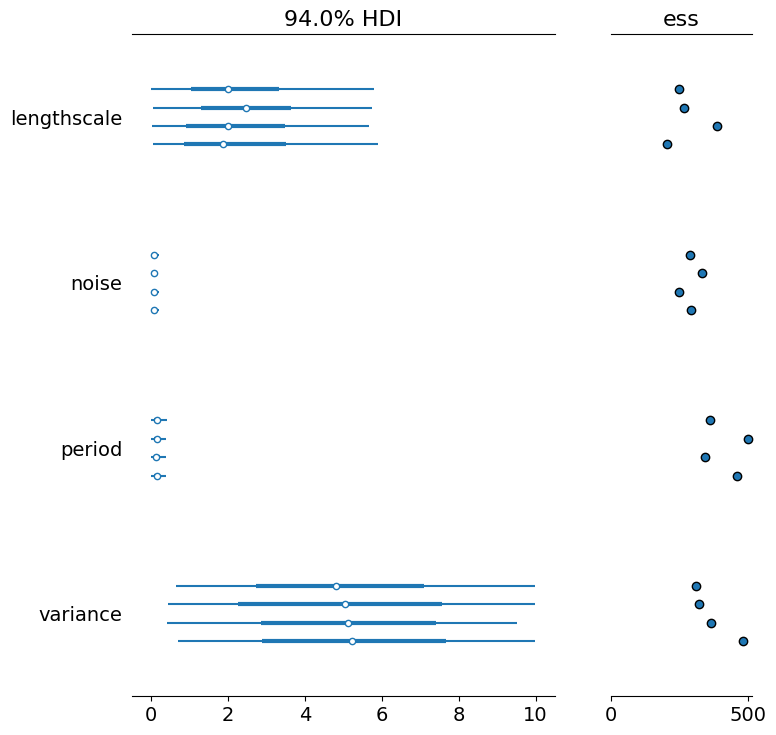

In [157]:
###Arviz diagnostics

posterior_data = az.from_pyro(mcmc)

print(az.summary(posterior_data))
az.plot_trace(posterior_data)
az.plot_autocorr(posterior_data)
az.plot_forest(posterior_data, ess = True)

In [161]:
def approximate_posterior_log_likelihood(samples, x_test, y_test):
    sampled_variances = samples["variance"].detach().numpy()
    sampled_lengthscales = samples["lengthscale"].detach().numpy()
    sampled_periods = samples["period"].detach().numpy()
    sampled_noises = samples["noise"].detach().numpy()

    #500 samples
    num_samples_to_use = 500
    selected_indices = np.random.choice(len(sampled_variances), num_samples_to_use, replace=False)

    selected_variances = sampled_variances[selected_indices]
    selected_lengthscales = sampled_lengthscales[selected_indices]
    selected_periods = sampled_periods[selected_indices]
    selected_noises = sampled_noises[selected_indices]

    #Compute the approximate posterior log-likelihood
    log_likelihoods = []

    for var, length, period, noise in zip(selected_variances, selected_lengthscales, selected_periods, selected_noises):

        period_kernel = gp.kernels.Periodic(
            input_dim = 1, variance = torch.tensor(var),
            lengthscale=torch.tensor(length), period=torch.tensor(period)
        )

        rbf_kernel = gp.kernels.RBF(
            input_dim = 1, variance = torch.tensor(var),
                            lengthscale=torch.tensor(length)
        )

        combined_kernel = gp.kernels.Product(
            period_kernel, rbf_kernel
        )

        kernel = combined_kernel

        gpr = gp.models.GPRegression(x_train, y_train, kernel, noise=torch.tensor(noise))

        #Compute predictive distribution
        with torch.no_grad():
            predictive_mean, predictive_cov = gpr(x_test, full_cov=True, noiseless=False)

        predictive_distribution = dist.MultivariateNormal(predictive_mean, predictive_cov)

        #log-likelihood of the test outputs
        log_likelihood = predictive_distribution.log_prob(y_test)
        log_likelihoods.append(log_likelihood.item())

    #Approximate posterior log-likelihood
    approximate_posterior_log_likelihood = np.mean(log_likelihoods)

    return approximate_posterior_log_likelihood

approximate_posterior_log_likelihood(samples, xis_test, yis_test)

-16.524818994835215

### Testing for 20 different datasets (to be finished)

In [ ]:
res_df = pd.DataFrame()
map_likelihoods = []
posterior_log_likelihoods = []

for i in range(1, 21):
    print(i)
    x_train, x_test, y_train, y_test = generate_dataset(random_state = i)
    pyro.clear_param_store()

    #MAP
    gpr = get_gpr(x_train, y_train, variance_prior, lengthscale_prior, period_prior, noise_prior)
    optimizer = torch.optim.Adam(gpr.parameters(), lr=0.002)
    loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
    losses = []
    num_steps = 2000
    for i in range(num_steps):
        optimizer.zero_grad()
        loss = loss_fn(gpr.model, gpr.guide)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    map_likelihood = log_likelihood(gpr, x_test, y_test)
    print(map_likelihood)
    map_likelihoods.append(map_likelihood)

    #NUTS
    pyro.clear_param_store()
    nuts = NUTS(model)
    mcmc = MCMC(nuts, num_samples=500, warmup_steps=250, num_chains = 4)
    mcmc.run(x_train, y_train)
    samples = mcmc.get_samples()
    posterior_log_likelihood = approximate_posterior_log_likelihood(samples, x_test, y_test)
    print(posterior_log_likelihood)
    posterior_log_likelihoods.append(posterior_log_likelihood)

1


/usr/local/lib/python3.10/dist-packages/pyro/infer/mcmc/api.py:499: UserWarning: num_chains=4 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(


-8.099032386280653


Sample [3]: 100%|██████████| 750/750 [00:31, 23.89it/s, step size=3.14e-01, acc. prob=0.932]


-115.72616633529849
2
10.859801423168756


Sample [3]: 100%|██████████| 750/750 [00:28, 26.48it/s, step size=4.17e-01, acc. prob=0.919]


-30.11104549014804
3
-10.297995292763868


Warmup [1]:  30%|███       | 227/750 [00:11, 21.54it/s, step size=2.02e-01, acc. prob=0.781]